# Basketball Lineup Plus-minus Prediction Via Regression


##### Kole Laviolette 72088131
##### Jerry Qi 73382533
##### Junru Chen 74767625
##### Suryansh Aggarwal 86345881

In [1]:
library(tidyverse)
library(tidymodels)
library(GGally)
library(gtable)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Introduction 

In basketball, there is a statistic called the “plus-minus” (short-handed to “+/-”) that refers to the sum of all of the points scored while they were on the court, minus the sum of all the points they let the opposing team score.[1] This statistic is a good quantifiable value for the overall effect of a line in a basketball game, and it can be used to determine the best line for a team to play in a game. The  biggest  advantage  of  plus/minus  statistics  is  that  they  account  for  a player's  contributions  that  are  not  tracked  by  the  box  score. [2]
In our project, our group is trying to approximate the plus-minus of a certain line in a basketball game using the general statistics of a line during a game.

Our dataset contains the statistics of various NBA lineups. In every row of our dataset, there are the team names, players in a certain lineup, and all recorded statistics during the game such as the points scored, three-point shots made, minutes played, etc.

<img src="https://media1.giphy.com/media/xTiTnpcaFPfJAzaP8A/giphy.gif?cid=ecf05e47vmgx3augez5b3eixpieipismv4h1zt1trjuv3zx9&rid=giphy.gif&ct=g" width = "400"/>

Source : https://media1.giphy.com/media/xTiTnpcaFPfJAzaP8A/giphy.gif?cid=ecf05e47vmgx3augez5b3eixpieipismv4h1zt1trjuv3zx9&rid=giphy.gif&ct=g

## Preliminary exploratory data analysis

#### The predictors we initially plan to use are listed below:

Normally people think the more points players get, or the higher hit rate players have, the more positive effect they will have so we will use PTS  and FGP as two predictors.

`PTS` : points scored

`FGP` : hit rate percentage of all shots

For professional statistics who know more about basketball and dig research on each game, they will consider PIR (an addition index consisting of positive actions minus negative actions), TSP (an index that balances points, field goal attempts, and free throw attempts), PPP (an index calculates points per possession is an advanced statistic that attempts to measure the number of points a player generates for each possession of the ball) can influence the effect of players on the game, so we will use these three indexes as predictors.

`PIR` : Performance Index Ranking 

`TSP` : True Shooting Percentage 

`PPP` : Points Per Possession 

Loading dataset from the original source on the web is our first step of exploring data.

In [2]:
lineup_stat <- read_csv("https://raw.githubusercontent.com/JerryQi77/DSCI_Group-Project/main/DSCI_Group_project?token=GHSAT0AAAAAABZQJWZPOUAKKT7OY7UAZ33IY2546GQ")

Rows: 250 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (6): TEAM, First Player, Second Player, Third Player, Fourth Player, Fi...
dbl (24): ...1, GP, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, O...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Once the data is read, we attempt to wrangles and cleans the data frame by calculating new index through official formula and keeping the columns we plan to choose as predictors in regression model.

;!!! there need to have citation of the formulas

`PIR` = (Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed) [1]

`TSP` = Points ÷ ((2 x Field Goal Attempts) + (0.88 x Free Throw Attempts) [2]


`PPP` = Points ÷ (Field Goal Attempts + (0.44 x Free Throw Attempts) + Turnovers) [1]


In [3]:
colnames(lineup_stat)[colnames(lineup_stat) == "+/-"] <- "P_M"
colnames(lineup_stat)[colnames(lineup_stat) == "FG%"] <- "FGP"
lineup_stat_1 <- select(lineup_stat, GP:P_M)

lineup_stat_2 <- lineup_stat_1 |>
                 mutate(PIR = PTS + REB + AST + STL + BLK + PFD + FGM - FGA + FTM - FTA - TOV - BLKA - PF) |>
                 mutate(TSP = PTS / ((2 * FGA) + (0.88 * FTA))) |>
                 mutate(PPP = PTS / (FGA + (0.44 * FTA) + TOV))|>
                 select(PTS,FGP,PIR,TSP,PPP,P_M)

Then we split our data to make sure only the training data is used during the data process and the testing data wouldn't be processed.

In [4]:
set.seed(96)
lineup_split <- initial_split(lineup_stat_2, prop = 0.75, strata = P_M)
lineup_train <- training(lineup_split)
lineup_testing <- testing(lineup_split)

After setting our training dataset from the original dataset, we summarized our training data by calculating the total groups number, the mean value of our predictos and the value `P_M` that we want to preditct.

In [5]:
lineup_train_sum <- lineup_train|>select(PTS:P_M)|>summarize(total_groups = n(),PTS_mean=mean(PTS),FGP_mean=mean(FGP),PIR_mean=mean(PIR),TSP_mean=mean(TSP),PPP_mean=mean(PPP),P_M_mean=mean(P_M))
lineup_train_sum 

total_groups,PTS_mean,FGP_mean,PIR_mean,TSP_mean,PPP_mean,P_M_mean
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186,17.02849,46.69892,19.02097,0.5632984,0.9865362,0.5612903


Then, we use ggpair to see the relationship between our five predictors and target value separately, and the distribution of our six values.

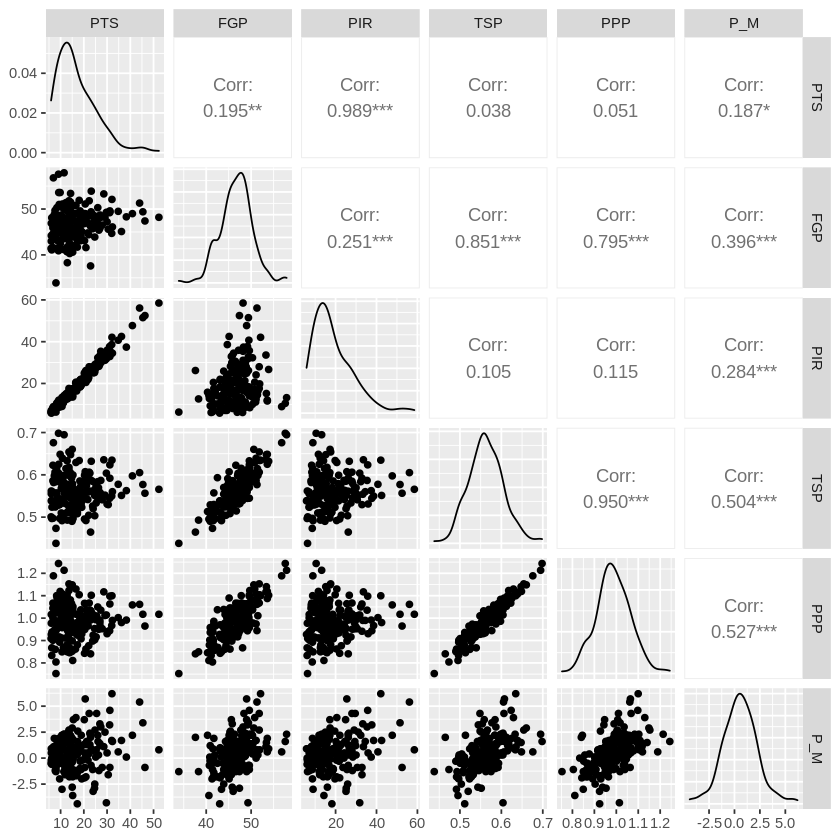

In [6]:
relationship <- lineup_train|>ggpairs()
relationship

>**Figure 1:**

In [7]:
pts_plot <- ggplot(lineup_train, aes(x = PTS, y = P_M)) + geom_point() +
            xlab("Points") + ylab("Plus Minus") + theme(text = element_text(size=16))

fgp_plot <- ggplot(lineup_train, aes(x = FGP, y = P_M)) + geom_point() +
            xlab("Field Goals Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

pir_plot <- ggplot(lineup_train, aes(x = PIR, y = P_M)) + geom_point() +
            xlab("Performance index rating") + ylab("Plus Minus") + theme(text = element_text(size=16))

tsp_plot <- ggplot(lineup_train, aes(x = TSP, y = P_M)) + geom_point() +
            xlab("True Shooting Percentage") + ylab("Plus Minus") + theme(text = element_text(size=16))

ppp_plot <- ggplot(lineup_train, aes(x = PPP, y = P_M)) + geom_point() +
            xlab("Points per possession") + ylab("Plus Minus") + theme(text = element_text(size=16))

From the graphs, we can know that PPP and TSP have more strong relationship with P_M so they would be better predictors than others.

We use PPP and TSP as our predictors and do knn & linear regression with them to compare which model could better predic the value with less error.

let's start with KNN regression. Since we don't know the exact number of neighbors which would bring the best outcome, we should find out the neighbors first.

We’ll use cross-validation on our training data to choose $k$.

First, we set our model as $k$-nn regression and create recipe using PPP and TSP as predictors, using training data to make sure testing data won't involve. We also scale all the predictors because we want our predictors can equally affected the predicted label despite their magnitude of their values.

After creating model and recipe, we split our training dataset equally into five different subsets and create gridvals from 1 neighbor to 30 neighbors.

Using workflow function, we run our regression model using neighbors from 1 to 30 on the five subsets to see the results of all the neighbors.

In [8]:
set.seed(96)
lineup_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
      set_engine("kknn") |>
      set_mode("regression") 

lineup_recipe <- recipe(P_M ~ PPP + TSP, data = lineup_train) |>
      step_scale(all_predictors()) |>
      step_center(all_predictors())

lineup_vfold <- vfold_cv(lineup_train, v = 5, strata = P_M)

gridvals <- tibble(neighbors = seq(1, 30))

lineup_results <- workflow() |> 
    add_recipe(lineup_recipe) |> 
    add_model(lineup_spec) |>
    tune_grid(resamples = lineup_vfold, grid = gridvals) |> 
    collect_metrics()

In the context of $k$-nn *regression*, we use RMPSE instead of accuracy in classification. If the prediction values are very close to the true values, the RMSPE will be small. Conversely, if the prediction values are *not* very close to the true values, the RMSPE will be quite large. In other words, the neighbor that would bring the smallest RMSE would be our best choice for neighbors. And from the chart below it's pretty clear that 18 neighbors would be the best choice.


In [9]:
# show only the row of minimum RMSPE
lineup_min <- lineup_results |>
   filter(.metric == "rmse") |>
   arrange(mean) |> 
   head(1)

lineup_min

k_min <- lineup_min |>
         pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
18,rmse,standard,1.445318,5,0.07487702,Preprocessor1_Model18


>**Table 1:**

After knowing the best choice of neighbors, let's bring it back to our regression model by creating and using the new lineup_spec of 18 neighbors to see how it would perform on our testing dataset. 

In [19]:
lineup_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
         set_engine("kknn") |>
         set_mode("regression")

lineup_best_fit <- workflow() |>
         add_recipe(lineup_recipe) |>
         add_model(lineup_best_spec) |>
         fit(data = lineup_train)

lineup_summary <- lineup_best_fit |>
          predict(lineup_testing) |>
          bind_cols(lineup_testing) |>
          metrics(truth = P_M, estimate = .pred)



$k$-nn regression model's rmse doesn't seem good because 1.793 rmse is too big since most value of P_M is between $-2.5$ and $3$ so we would like to try linear regression instead to see if RMSE would be better.

In [20]:
lineup_summary|>filter(.metric == "rmse")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.792903


There should be a 3D graph

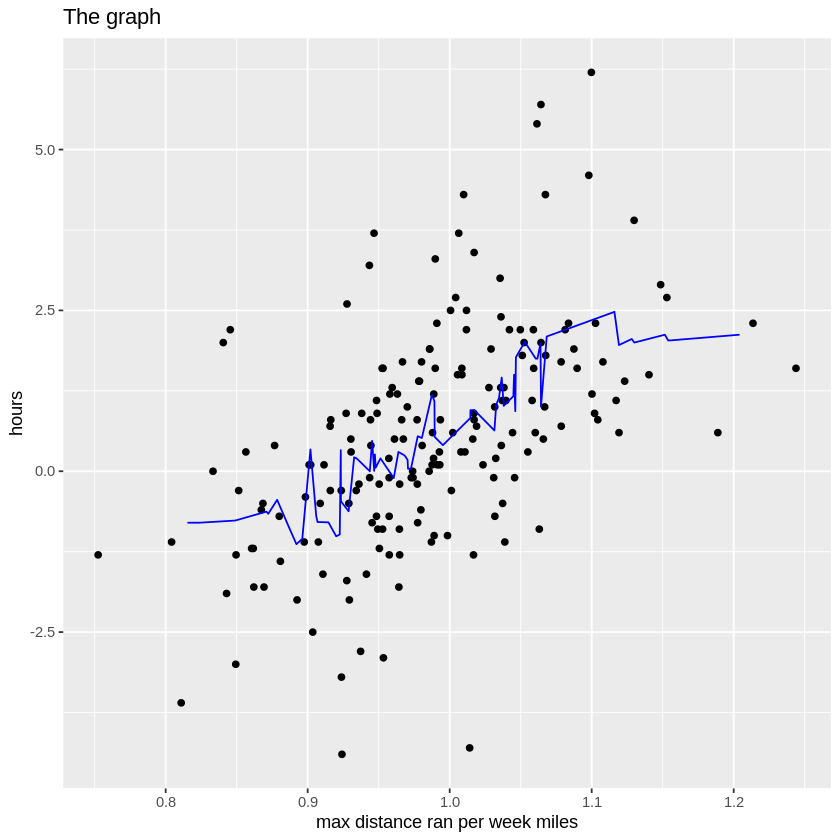

In [21]:
lineup_preds <- lineup_best_fit|>predict(lineup_testing)|>bind_cols(lineup_testing)
lineup_k_plot <- ggplot(data = lineup_train, aes(x = PPP, y = P_M)) + geom_point() + geom_line(data = lineup_preds, color = "blue", mapping = aes(x = PPP, y= .pred))+
labs(x = "max distance ran per week miles", y = "hours") + ggtitle("The graph")
lineup_k_plot

>**Figure 2:**

Just like $k$-nn regression, we set model as linear regression and create recipe using PPP and TSP as predictors on training data.  

In [13]:
lineup_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lineup_recipe <- recipe(P_M ~ PPP + TSP, data = lineup_train)

We add them to workflow function and see how's the linear regression model generated based on training data.

In [14]:
lineup_fit <- workflow() |>
  add_recipe(lineup_recipe) |>
  add_model(lineup_spec) |>
  fit(data = lineup_train)
lineup_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          PPP          TSP  
    -10.758       10.671        1.407  


Then, we use our regression model on testing data to see how's the rmse.

In [16]:
lineup_test_results <- lineup_fit |>
  predict(lineup_testing) |>
  bind_cols(lineup_testing) |>
  metrics(truth = P_M, estimate = .pred)

lineup_test_results


# Take this step if you want the RMSPE value.
lineup_rmspe <- lineup_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lineup_rmspe

coeffs <- lineup_fit |>
             extract_fit_parsnip() |>
             tidy()
coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.7533693
rsq,standard,0.3349985
mae,standard,1.1921460


[1] 1.753369

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-10.757996,1.428750,-7.5296586,2.245191e-12
PPP,10.670622,4.356799,2.4491882,1.525959e-02
TSP,1.406593,8.114289,0.1733477,8.625697e-01


During our project, we are expecting to find which one of our five predictors is the best at predicting the plus-minus of a line and therefore the overall effect the line has in a game. This information could give NBA Scouts and General Managers more insight into a player's performance and allow them to trade or draft players most beneficial to their team.

Some future questions that may be asked after our initial question is answered are:

- Is the Euroleague’s Performance Index Rating an accurate representation of the performance of a lineup in a game? It is used to scout and draft players in the Euroleague and with our initial question answered, we may be able to verify the accuracy of this index

- Does this reflect the overall teamwork between players or is this a reflection of the individual skills of each player on a team? Answering this question can show the effect a single "superstar" player can have on a single lineup.

## References

[1] : Fromal, A. (2017, October 3). Understanding the NBA: Explaining Advanced Comprehensive Stats and Metrics. Bleacher Report.
              https://bleacherreport.com/articles/1040320-understanding-the-nba-explaining-advanced-comprehensive-stats-and-metrics


[2] : Kubatko, Justin; Oliver, Dean; Pelton, Kevin; and Rosenbaum, Dan T. (2007) 
            "A Starting Point for Analyzing Basketball Statistics," Journal of Quantitative Analysis in Sports : 
             Vol. 3: Iss. 3, Article 1
 

[3] : Wikipedia contributors. (2022b, March 14). Performance Index Rating. Wikipedia. https://en.wikipedia.org/3iki/Performance_Index_Rating

[4] : Wikipedia contributors. (2022c, June 15). True shooting percentage. Wikipedia. https://en.wikipedia.org/wiki/True_shooting_percentage